<a href="https://colab.research.google.com/github/karnabrajesh/Learning/blob/master/ExploratoryAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import string
import re

In [3]:
def load_tweets():
    return pd.read_csv('/content/sample_data/trump_tweets.csv')

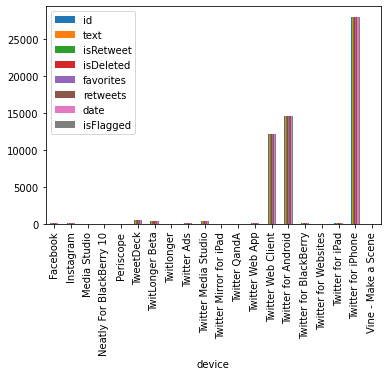

In [4]:
tweet_df = load_tweets()
group_df = tweet_df.groupby('device')

#get all the group values
all_groups_df = pd.DataFrame(group_df.first())

#convert index for our case the devices names
devices = all_groups_df.index.values.tolist()

#Group size
group_size = group_df.size()
group_df.count().plot.bar()

#based on number of tweets only considering those device:
# Twitter Web Client
#Twitter for Android
#Twitter for iphone


twitter_for_iPhone_df = group_df.get_group('Twitter for iPhone').set_index(['date']).sort_index()
twitter_web_client_df = group_df.get_group('Twitter Web Client').set_index(['date']).sort_index()
twitter_for_android_df = group_df.get_group('Twitter for Android').set_index(['date']).sort_index()